In [26]:
import damask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [27]:
resultfile_path = 'reference_output/tensionX_material_fullfield_10materials_6ferrite_4martensite_10grains_voronoi_5x5x5/simulation_output.hdf5'

In [28]:
result = damask.Result(resultfile_path)
if isinstance(result.view(increments=0).get('F'), np.ndarray):
    raise RuntimeError('The selected resultfile comes from a single phase simulation, please use post_processing_fullfield.ipynb for this file instead')

try:
    result.add_stress_Cauchy()
except ValueError:
    pass
try:
    result.add_equivalent_Mises('sigma')
except ValueError:
    pass
try:
    result.add_stress_second_Piola_Kirchhoff()
except ValueError:
    pass

try:
    result.add_strain()
except ValueError:
    pass

postprossecing_dir = Path(resultfile_path).stem
vti_path = list(Path(resultfile_path).parent.glob("*.vti"))[0]
material_path = list(Path(resultfile_path).parent.glob("material*"))[0]
grid = damask.GeomGrid.load(vti_path)

with open(material_path, 'r') as f:
    material_dict = yaml.load(f)
material_grid_mapping = {}
for id, material in enumerate(material_dict['material']):
    phase = material['constituents'][0]['phase']
    if not phase in material_grid_mapping:
        material_grid_mapping[phase] = []
    material_grid_mapping[phase].append(id)
material_grid_mapping

/tmp/ipykernel_4011140/2177309841.py:29: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  material_dict = yaml.load(f)


{'Ferrite': [0, 1, 2, 3, 4, 5], 'Martensite': [6, 7, 8, 9]}

In [29]:
type(result.view(increments=0).get('F'))

dict

In [30]:
result

Created by DAMASK_grid v3.0.0
        on 2024-10-25 11:58:13+0200
 executing "DAMASK_grid -g 10grains_voronoi_5x5x5.vti -l tensionX.yaml -m material_fullfield_10materials_6ferrite_4martensite.yaml -w reference_output/tensionX_material_fullfield_10materials_6ferrite_4martensite_10grains_voronoi_5x5x5 -j simulation_output"

increment_0 (0.0 s)
  phase
    Ferrite
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / 1: crystal orientation as quaternion q_0 (q_1 q_2 q_3)
        P / Pa: first Piola-Kirchhoff stress
        S / Pa: second Piola-Kirchhoff stress calculated from P (first Piola-Kirchhoff stress) and F (deformation gradient)
        epsilon_V^0.0(F) / 1: Seth-Hill strain tensor of order 0.0 based on left stretch tensor of F (deformation gradient)
        gamma_sl / 1: plastic shear
        sigma / Pa: Cauchy stress calculated from P (first Piola-Kirchhoff stress) and F (deform

/tmp/ipykernel_4011140/116318971.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data[phase] = pd.concat((data[phase],grain_data),ignore_index=True)
/tmp/ipykernel_4011140/116318971.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data[phase] = pd.concat((data[phase],grain_data),ignore_index=True)


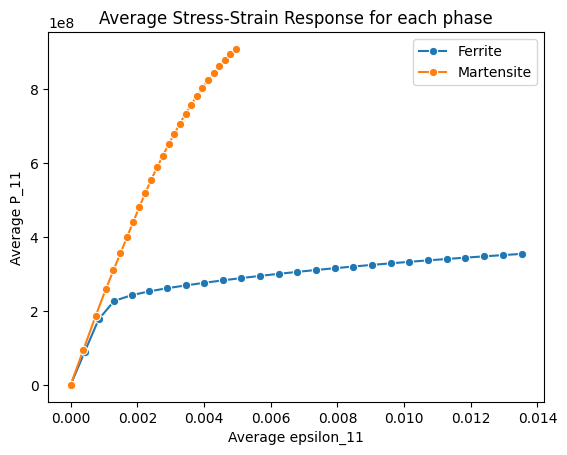

In [31]:
def plot_stress_strain_multiphase(grid, result):
    data = {}
    for phase in result.view(increments=0).get(['epsilon_V^0.0(F)','P']).keys():
        data[phase] = pd.DataFrame(columns=['F_11', 'P_11'])
    for phases in result.get(['epsilon_V^0.0(F)','P']).values():
        for phase, inc in phases.items():
            P = inc['P']
            epsilon = inc['epsilon_V^0.0(F)']
            for g in material_grid_mapping[phase]:
                material_phase = ([i for i in grid.material.flatten(order='F') if i in material_grid_mapping[phase]])
                points = np.array(material_phase) == g
                P_11 = P[points,0,0].flatten()
                epsilon_11 = np.broadcast_to(np.average(epsilon[:,0,0]),P_11.shape)
                grain_data = pd.DataFrame({'epsilon_11':epsilon_11,'P_11':P_11})
                data[phase] = pd.concat((data[phase],grain_data),ignore_index=True)

    for phase in result.view(increments=0).get(['epsilon_V^0.0(F)','P']).keys():
        average_data = data[phase].groupby('epsilon_11', as_index=False).mean()
        sns.lineplot(x='epsilon_11', y='P_11', data=average_data, marker='o', label=phase)
    plt.xlabel("Average epsilon_11")
    plt.ylabel("Average P_11")
    plt.title("Average Stress-Strain Response for each phase")
    plt.show()


plot_stress_strain_multiphase(grid, result)
